In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from transformers import BertTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense,Dropout, SimpleRNN,LSTM
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


In [2]:
# Load data from CSV
data = pd.read_json("Sarcasm_Headlines_Dataset.json",lines=True)

# Split data into sentences and labels
sentences = data["headline"].values
labels = data["is_sarcastic"].values
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


Sample Headlines:
1. former versace store clerk sues over secret 'black code' for minority shoppers

2. the 'roseanne' revival catches up to our thorny political mood, for better and worse

3. mom starting to fear son's web series closest thing she will have to grandchild

4. boehner just wants wife to listen, not come up with alternative debt-reduction ideas

5. j.k. rowling wishes snape happy birthday in the most magical way



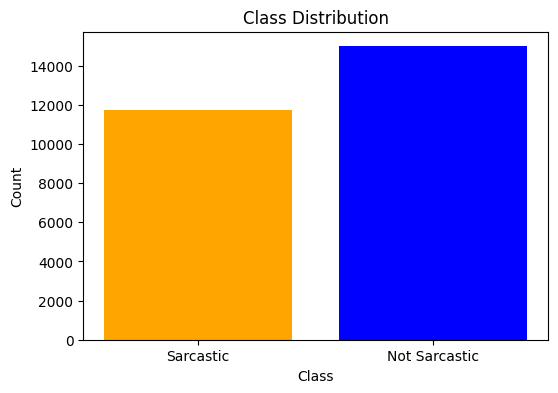

ModuleNotFoundError: No module named 'wordcloud'

In [3]:
import matplotlib.pyplot as plt

# Display sample data points
print("Sample Headlines:")
for i in range(5):
    print(f"{i+1}. {sentences[i]}")
    print()

# Plot class distribution
plt.figure(figsize=(6, 4))
plt.bar(['Sarcastic', 'Not Sarcastic'], [sum(labels), len(labels) - sum(labels)], color=['orange', 'blue'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Generate word cloud
from wordcloud import WordCloud

all_text = ' '.join(sentences)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Headlines')
plt.show()


In [4]:
max_sentence_length = max(len(sentence) for sentence in sentences)
print(max_sentence_length)

254


In [6]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

def get_bert_embeddings(sentences, max_length=256, batch_size=8):
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.eval()  # Set model to evaluation mode

    all_embeddings = []

    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        tokenized_batch = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

        with torch.no_grad():
            outputs = model(**tokenized_batch)
            embeddings = outputs.last_hidden_state.numpy()

        all_embeddings.append(embeddings)

    # Pad arrays to the same size
    max_len = max(embedding.shape[1] for embedding in all_embeddings)
    padded_embeddings = [np.pad(embedding, ((0, 0), (0, max_len - embedding.shape[1]), (0, 0)), mode='constant', constant_values=0) for embedding in all_embeddings]

    # Convert the list of arrays to a single numpy array
    return np.concatenate(padded_embeddings, axis=0)

# Example usage:
train_embeddings = get_bert_embeddings(train_sentences.tolist())
test_embeddings = get_bert_embeddings(test_sentences.tolist())


In [ ]:
"""
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

max_sequence_length = 128
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

input_length = max_sequence_length
vocab_size = len(tokenizer.word_index) + 1
"""

In [12]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout

def create_cnn_model(input_dim, max_len):
    model = Sequential()
    model.add(Conv1D(128, 5, activation='relu', input_shape=(max_len, input_dim)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define input dimensions
input_dim = train_embeddings.shape[2]  # Dimension of BERT embeddings
max_len = train_embeddings.shape[1]  # Maximum sequence length

# Create CNN model
cnn_model = create_cnn_model(input_dim, max_len)

# Compile CNN model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN model
cnn_model.fit(train_embeddings, train_labels, epochs=5, validation_data=(test_embeddings, test_labels))


Epoch 1/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.8067 - loss: 0.4150 - val_accuracy: 0.8939 - val_loss: 0.2628
Epoch 2/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9079 - loss: 0.2256 - val_accuracy: 0.8993 - val_loss: 0.2565
Epoch 3/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.9420 - loss: 0.1503 - val_accuracy: 0.8991 - val_loss: 0.2718
Epoch 4/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.9608 - loss: 0.0966 - val_accuracy: 0.9015 - val_loss: 0.2789
Epoch 5/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.9792 - loss: 0.0583 - val_accuracy: 0.8948 - val_loss: 0.4043


In [8]:
np.save("train_embeddings.npy", train_embeddings)
np.save("test_embeddings.npy", test_embeddings)

In [9]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout

def create_rnn_model(input_dim, max_len):
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=(max_len, input_dim)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define input dimensions
input_dim = train_embeddings.shape[2]  # Dimension of BERT embeddings
max_len = train_embeddings.shape[1]  # Maximum sequence length

# Create RNN model
rnn_model = create_rnn_model(input_dim, max_len)

# Compile RNN model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train RNN model
rnn_model.fit(train_embeddings, train_labels, epochs=5, validation_data=(test_embeddings, test_labels))


C:\Users\aadit\OneDrive\Desktop\College Stuff\C\python\TDL\cuda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

KeyboardInterrupt



In [12]:
"""
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def create_lstm_model(input_dim, max_len):
    model = Sequential()
    model.add(LSTM(128, input_shape=(max_len, input_dim)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define input dimensions
input_dim = train_embeddings.shape[2]  # Dimension of BERT embeddings
max_len = train_embeddings.shape[1]  # Maximum sequence length

# Create LSTM model
lstm_model = create_lstm_model(input_dim, max_len)

# Compile LSTM model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train LSTM model
lstm_model.fit(train_embeddings, train_labels, epochs=5, validation_data=(test_embeddings, test_labels))
"""

Epoch 1/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.7648 - loss: 0.4928 - val_accuracy: 0.8182 - val_loss: 0.3957
Epoch 2/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.8758 - loss: 0.3138 - val_accuracy: 0.8697 - val_loss: 0.3180
Epoch 3/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.9066 - loss: 0.2418 - val_accuracy: 0.8590 - val_loss: 0.3332
Epoch 4/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.9204 - loss: 0.2012 - val_accuracy: 0.8645 - val_loss: 0.2929
Epoch 5/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.9381 - loss: 0.1600 - val_accuracy: 0.8955 - val_loss: 0.2810


In [10]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout

def create_bidirectional_lstm_model(input_dim, max_len):
    model = Sequential()
    model.add(Bidirectional(LSTM(128), input_shape=(max_len, input_dim)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define input dimensions
input_dim = train_embeddings.shape[2]  # Dimension of BERT embeddings
max_len = train_embeddings.shape[1]  # Maximum sequence length

# Create bi-directional LSTM model
bidirectional_lstm_model = create_bidirectional_lstm_model(input_dim, max_len)

# Compile bi-directional LSTM model
bidirectional_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train bi-directional LSTM model
bidirectional_lstm_model.fit(train_embeddings, train_labels, epochs=5, validation_data=(test_embeddings, test_labels))


C:\Users\aadit\OneDrive\Desktop\College Stuff\C\python\TDL\cuda\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 133s 193ms/step - accuracy: 0.8282 - loss: 0.3796 - val_accuracy: 0.8804 - val_loss: 0.2781
Epoch 2/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 118s 176ms/step - accuracy: 0.9037 - loss: 0.2317 - val_accuracy: 0.9025 - val_loss: 0.2357
Epoch 3/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 118s 176ms/step - accuracy: 0.9375 - loss: 0.1636 - val_accuracy: 0.9088 - val_loss: 0.2265
Epoch 4/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 114s 171ms/step - accuracy: 0.9556 - loss: 0.1114 - val_accuracy: 0.9111 - val_loss: 0.2390
Epoch 5/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 108s 161ms/step - accuracy: 0.9744 - loss: 0.0696 - val_accuracy: 0.9058 - val_loss: 0.2925


In [14]:


# Save the weights of CNN model
# Save the weights of CNN model
cnn_model.save_weights("cnn_model_weights.weights.h5")


In [15]:

bidirectional_lstm_model.save_weights("bidirectional_lstm_model_weights.weights.h5")


In [21]:
# Check the shape of the embeddings before reshaping
print("Shape of train_embeddings:", train_embeddings.shape)
print("Shape of test_embeddings:", test_embeddings.shape)


Shape of train_embeddings: (21367, 66, 768)
Shape of test_embeddings: (5342, 37, 768)


In [22]:
from sklearn.naive_bayes import GaussianNB
from keras.preprocessing.sequence import pad_sequences

# Initialize Naive Bayes classifier
naive_bayes_classifier = GaussianNB()

# Define the maximum sequence length
max_len = 66  # Maximum sequence length

# Pad or truncate the test embeddings to match the sequence length of train embeddings
test_embeddings_adjusted = pad_sequences(test_embeddings, maxlen=max_len, padding='post', truncating='post', dtype='float32')

# Reshape the embeddings for Naive Bayes input
train_embeddings_reshaped = train_embeddings.reshape(train_embeddings.shape[0], -1)
test_embeddings_reshaped = test_embeddings_adjusted.reshape(test_embeddings_adjusted.shape[0], -1)

# Train the Naive Bayes classifier
naive_bayes_classifier.fit(train_embeddings_reshaped, train_labels)

# Evaluate the model
accuracy = naive_bayes_classifier.score(test_embeddings_reshaped, test_labels)
print("Accuracy:", accuracy)


Accuracy: 0.5688880569075253


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from keras.preprocessing.sequence import pad_sequences

# Define the maximum sequence length
max_len = 66  # Maximum sequence length

# Pad or truncate the test embeddings to match the sequence length of train embeddings
test_embeddings_adjusted = pad_sequences(test_embeddings, maxlen=max_len, padding='post', truncating='post', dtype='float32')

# Reshape the embeddings for KNN input
train_embeddings_reshaped = train_embeddings.reshape(train_embeddings.shape[0], -1)
test_embeddings_reshaped = test_embeddings_adjusted.reshape(test_embeddings_adjusted.shape[0], -1)

# Initialize KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors as needed

# Train the KNN classifier
knn_classifier.fit(train_embeddings_reshaped, train_labels)

# Evaluate the model
accuracy = knn_classifier.score(test_embeddings_reshaped, test_labels)
print("Accuracy:", accuracy)


Accuracy: 0.7701235492324972


In [27]:
from sklearn.neighbors import KNeighborsClassifier
from keras.preprocessing.sequence import pad_sequences

# Define the maximum sequence length
max_len = 66  # Maximum sequence length

# Pad or truncate the test embeddings to match the sequence length of train embeddings
test_embeddings_adjusted = pad_sequences(test_embeddings, maxlen=max_len, padding='post', truncating='post', dtype='float32')

# Reshape the embeddings for KNN input
train_embeddings_reshaped = train_embeddings.reshape(train_embeddings.shape[0], -1)
test_embeddings_reshaped = test_embeddings_adjusted.reshape(test_embeddings_adjusted.shape[0], -1)

# Initialize KNN classifier
knn_classifier64 = KNeighborsClassifier(n_neighbors=40)  # You can adjust the number of neighbors as needed

# Train the KNN classifier
knn_classifier64.fit(train_embeddings_reshaped, train_labels)

# Evaluate the model
accuracy = knn_classifier64.score(test_embeddings_reshaped, test_labels)
print("Accuracy:", accuracy)


Accuracy: 0.7787345563459378


In [22]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Combine the outputs of CNN and Bi-directional LSTM models
combined_features_train = np.concatenate((cnn_model.predict(train_embeddings),
                                          bidirectional_lstm_model.predict(train_embeddings)), axis=1)
combined_features_test = np.concatenate((cnn_model.predict(test_embeddings),
                                         bidirectional_lstm_model.predict(test_embeddings)), axis=1)

# Create and train SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(combined_features_train, train_labels)

# Make predictions on test data
svm_predictions = svm_model.predict(combined_features_test)

# Evaluate SVM model
svm_accuracy = accuracy_score(test_labels, svm_predictions)
print("SVM Accuracy:", svm_accuracy)


668/668 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
668/668 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
SVM Accuracy: 0.9198801946836391


In [30]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

# Get predictions from the KNN classifier on the training set
knn_train_predictions = knn_classifier64.predict(train_embeddings_reshaped)

# Combine the outputs of CNN, Bi-directional LSTM, and KNN models
combined_features_train = np.concatenate((cnn_model.predict(train_embeddings), 
                                          bidirectional_lstm_model.predict(train_embeddings),
                                          knn_train_predictions.reshape(-1, 1)), axis=1)
combined_features_test = np.concatenate((cnn_model.predict(test_embeddings), 
                                         bidirectional_lstm_model.predict(test_embeddings),
                                         knn_predictions.reshape(-1, 1)), axis=1)

# Create and train SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(combined_features_train, train_labels)

# Make predictions on test data
svm_predictions = svm_model.predict(combined_features_test)

# Evaluate SVM model
svm_accuracy = accuracy_score(test_labels, svm_predictions)
print("SVM Accuracy:", svm_accuracy)


668/668 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step
668/668 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
SVM Accuracy: 0.9166978659678023


In [33]:
import pickle

# Save the SVM model weights
with open("svm_model_weights.pkl", "wb") as f:
    pickle.dump(svm_model, f)
